In [44]:
import pandas as pd
import numpy as np

In [45]:
import pandas as pd

path = r"C:\Users\putri\SIAB_CBL\data\BBCA.JK_extended.csv"
df = pd.read_csv(path)

df.head()


,Date,Open,High,Low,Close,Volume
0,2014-12-08 00:00:00+00:00,2655.0,2680.0,2645.0,2655.0,37435500
1,2014-12-09 00:00:00+00:00,2660.0,2680.0,2630.0,2650.0,38254000
2,2014-12-10 00:00:00+00:00,2630.0,2675.0,2630.0,2660.0,32998000
3,2014-12-11 00:00:00+00:00,2660.0,2675.0,2645.0,2655.0,54459500
4,2014-12-12 00:00:00+00:00,2640.0,2665.0,2640.0,2650.0,50302000


In [46]:
import pandas as pd
import numpy as np

# pilih kolom yang dipakai
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [47]:
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)


In [48]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [49]:
df.duplicated().sum()

np.int64(0)

In [50]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

In [51]:
threshold = 0.003  # 0.3%

df['Return'] = (df['Close'].shift(-1) - df['Close']) / df['Close']

df['Label'] = np.where(df['Return'] > threshold, 1, 0)
df = df[:-1]


In [52]:
label_dist = df['Label'].value_counts().rename(index={1:'Naik', 0:'Turun'})
label_percent = (df['Label'].value_counts(normalize=True) * 100).rename(index={1:'Naik', 0:'Turun'})

pd.DataFrame({
    'Jumlah Data': label_dist,
    'Persentase (%)': label_percent.round(2)
})

,Jumlah Data,Persentase (%)
Label,,
Turun,1714,62.88
Naik,1012,37.12


In [53]:
# Moving Average 5 hari
df['MA5'] = df['Close'].rolling(window=5).mean()

# Moving Average 10 hari
df['MA10'] = df['Close'].rolling(window=10).mean()


In [54]:
df = df.dropna().reset_index(drop=True)

In [55]:
df.head()

,Date,Open,High,Low,Close,Volume,Return,Label,MA5,MA10
0,2014-12-19,2630.0,2650.0,2620.0,2635.0,83389500,-0.007590,0,2596.0,2625.0
1,2014-12-22,2650.0,2650.0,2615.0,2615.0,33301000,0.005736,1,2597.0,2621.0
2,2014-12-23,2640.0,2640.0,2625.0,2630.0,21132000,0.003802,1,2609.0,2619.0
3,2014-12-24,2650.0,2655.0,2635.0,2640.0,19135500,-0.003788,0,2623.0,2617.0
4,2014-12-29,2630.0,2650.0,2625.0,2630.0,24315000,-0.001901,0,2630.0,2614.5


In [56]:
X = df[
    [
        'Open',
        'High',
        'Low',
        'Close',
        'Volume',
        'MA5',
        'MA10',
        'Return',
    ]
]

y = df['Label']


In [57]:
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

In [58]:
print("Total data :", len(df))
print("Train data :", len(X_train))
print("Test data  :", len(X_test))


Total data : 2717
Train data : 2173
Test data  : 544


In [59]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [60]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train)


,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.8
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_metho

In [61]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Turun','Naik']))


Akurasi: 1.0
Confusion Matrix:
 [[351   0]
 [  0 193]]
              precision    recall  f1-score   support

       Turun       1.00      1.00      1.00       351
        Naik       1.00      1.00      1.00       193

    accuracy                           1.00       544
   macro avg       1.00      1.00      1.00       544
weighted avg       1.00      1.00      1.00       544



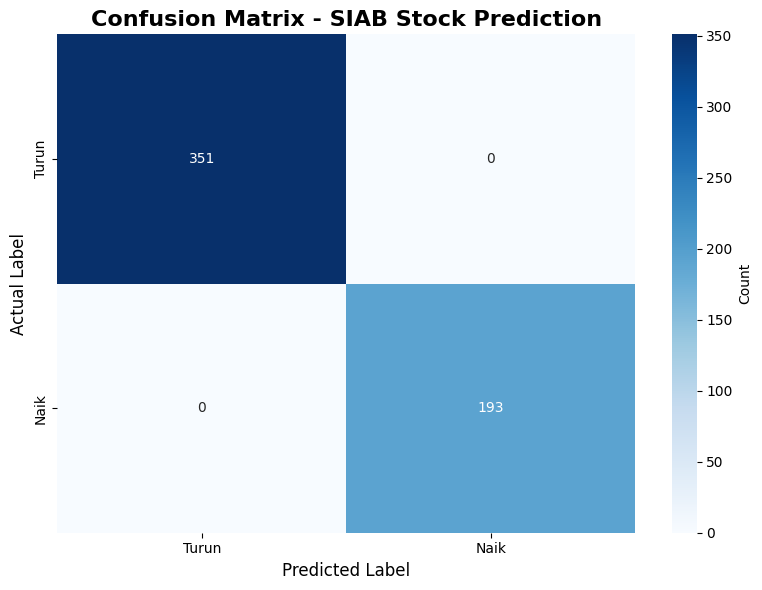

Akurasi: 1.0

Confusion Matrix:
[[351   0]
 [  0 193]]

Classification Report:
              precision    recall  f1-score   support

       Turun       1.00      1.00      1.00       351
        Naik       1.00      1.00      1.00       193

    accuracy                           1.00       544
   macro avg       1.00      1.00      1.00       544
weighted avg       1.00      1.00      1.00       544



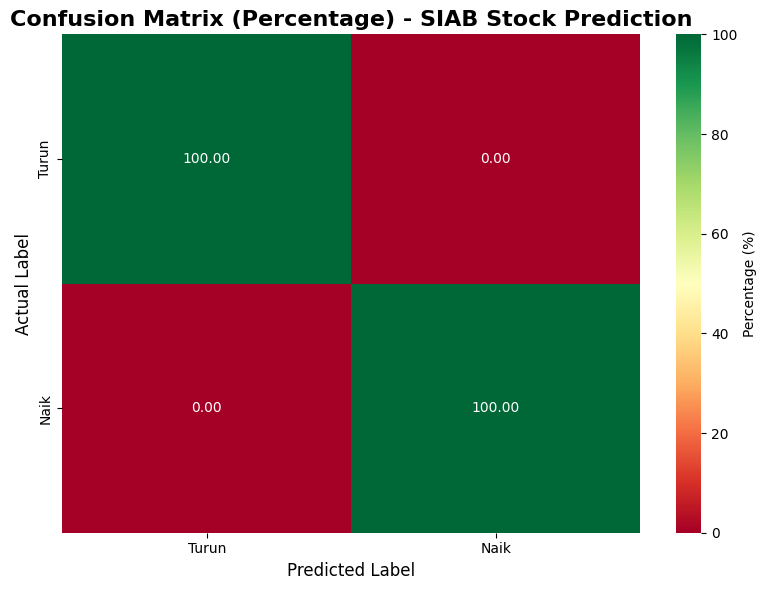

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

# Setelah Anda sudah punya y_test dan y_pred dari model

# 1. Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 2. Visualisasi dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Turun', 'Naik'], 
            yticklabels=['Turun', 'Naik'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - SIAB Stock Prediction', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# 3. Tampilkan metrik evaluasi
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Turun', 'Naik']))

# 4. (Opsional) Confusion Matrix dengan persentase
plt.figure(figsize=(8, 6))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='RdYlGn', 
            xticklabels=['Turun', 'Naik'], 
            yticklabels=['Turun', 'Naik'],
            cbar_kws={'label': 'Percentage (%)'})
plt.title('Confusion Matrix (Percentage) - SIAB Stock Prediction', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()